# Load data

## library 

In [1]:
import numpy as np 
import pandas as pd 

## load data 

In [3]:
train = pd.read_csv('dataset/train.csv', index_col = 'id')
test = pd.read_csv('dataset/test.csv', index_col = 'id')
submission = pd.read_csv('dataset/sample_submission.csv', index_col = 'id')

## Baseline model

LightGBM을 사용

# Feature Engineering 

## concat train/test

In [4]:
all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop('target', axis = 1)

all_features = all_data.columns 
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

## 명목형 피처 원-핫 인코딩

In [9]:
from sklearn.preprocessing import OneHotEncoder 

# 명목형 피처 추출 
cat_features = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder()

# 인코딩
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

## 필요없는 피처 제거

In [10]:
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
                 'ps_ind_13_bin', 'ps_car_14']

원-핫 인코딩을 수행한 명목형 피처, calc 분류의 피처, 추가로 제거할 피처를 제외한 나머지 피처를 **remaining_features**에 저장

In [12]:
remaining_features = [feature for feature in all_features if ('cat' not in feature and \
                                                             'calc' not in feature and \
                                                             feature not in drop_features)]

remaining_features와 명목형 피처 합치기

In [14]:
from scipy import sparse 

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                             format = 'csr')

## 데이터 나누기

In [29]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

# 평가지표 계산함수 작성

## 지니계수?
- 경제학에서 쓰는 용어
    - 지니계수가 작을수록 소득 수준이 평등하고, 클수록 불평등함을 의미 

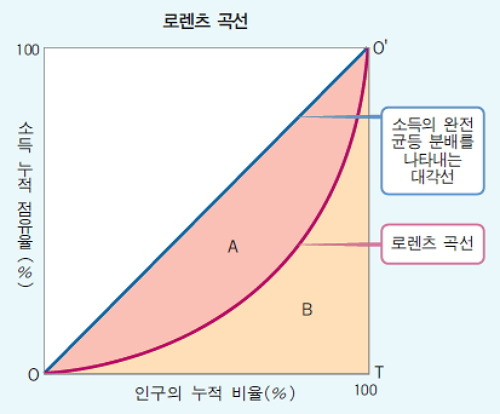

로렌츠 곡선을 이용해서 계산
- 1. 모든 경제인구를 소득 순으로 나열한 후에 가로 축은 인구 누적 비율, 세로 축은 소득 누적 점유율로 설정
- 2. 인구 누적 비율과 해당 소득 누적 점유율을 연결한 선을 로렌츠 곡선이라고 한다.
> 지니 계수 = $\dfrac{A}{A+B}$

## 정규화 지니계수 계산 함수 구현

In [22]:
def eval_gini(y_true, y_pred) : 
    # 실제값과 예측값의 크기가 서로 같은지 확인(다르면 에러 발생)
    assert y_true.shape == y_pred.shape
    
    # 데이터 개수
    n_samples = y_true.shape[0]
    # 대각선 값 
    L_mid = np.linspace(1/n_samples, 1, n_samples)
    
    # 1. 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()]
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    G_pred = np.sum(L_mid - L_pred)
    
    # 2. 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()]
    L_true = np.cumsum(true_order) / np.sum(true_order)
    G_true = np.sum(L_mid - L_true)
    
    # 정규화된 지니계수
    return G_pred / G_true

**모델 훈련 시 검증 파라미터에 전달하기 위한 함수**

In [25]:
# LGBM용 gini() 함수
def gini(preds, dtrain) : 
    labels = dtrain.get_label()
     # 마지막 True는 값이 클수록 성능이 좋은지의 여부
    return 'gini', eval_gini(labels, preds), True

# 모델 훈련 및 성능 검증

## OOF 기법

- 캐글에서 자주 사용하는 예측 기법인 OOF 사용
    - K-fold CV를 수행하면서 각 fold마다 테스트 데이터로 예측하는 방식 
    
> 즉, 1. 훈련 데이터로 훈련 > 2. 검증 데이터로 성능 측정 > 3. 테스트 데이터로 최종 타깃 확률도 예측

**OOF 예측 절차**
- 1. 전체 훈련 데이터를 K개의 그룹으로 분할
- 2. K개 그룹 중 한 그룹은 검증 데이터, 나머지 K-1개 그룹은 훈련 데이터로 지정
- 3. 훈련 데이터로 모델 훈련
- 4. 훈련된 모델을 이용해 검증 데이터로 타깃 확률을 예측하고, 전체 테스트 데이터로도 타깃 확률을 예측 
- 5. 검증 데이터로 구한 예측 확률과 테스트 데이터로 구한 예측 확률 기록
- 6. 2~5번 절차를 K번 반복
- 7. K개 그룹의 검증 데이터로 예측한 확률을 훈련 데이터 실제 타깃값과 비교해 성능 평가 점수 계산
- 8. 테스트 데이터로 구한 K개의 예측 확률의 평균 계산

## 장점 
- 1. 오버피팅 방지
- 2. 앙상블 효과를 기대할 수 있음 

## LGBM 훈련 

In [26]:
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1991)

In [27]:
params = {'objective' : 'binary', 
          'learning_rate' : [0.01], 
          'force_row_wise' : [True], 
          'random_state' : [0]}

In [46]:
# OOF 방식으로 훈련된 모델을 통한 검증 데이터 타깃값 예측 확률
oof_val_preds = np.zeros(X.shape[0])

# OOF 방식으로 훈련된 모델을 통한 테스트 데이터 타깃값 예측 확률
oof_test_preds = np.zeros(X_test.shape[0])

In [47]:
import lightgbm as lgb 

# OOF 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) : 
    print('#'*40, f'폴드 {idx+1} / {folds.n_splits}', '#'*40)
    
    # train/valid 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # LGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid)
    
    # 훈련
    lgb_model = lgb.train(params = params,
                          train_set = dtrain, 
                          num_boost_round = 1000, # 부스팅 반복 횟수
                          valid_sets = dvalid, 
                          feval = gini,
                          early_stopping_rounds = 100,
                          verbose_eval = 100)  # 100번째마다 점수 출력
    
    # 테스트 데이터를 통해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test) / folds.n_splits
    
    # 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score} \n')

######################################## 폴드 1 / 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.153354	valid_0's gini: 0.261651
[200]	valid_0's binary_logloss: 0.152426	valid_0's gini: 0.275704
[300]	valid_0's binary_logloss: 0.152023	valid_0's gini: 0.282277
[400]	valid_0's binary_logloss: 0.1518	valid_0's gini: 0.286648
[500]	valid_0's binary_logloss: 0.151713	valid_0's gini: 0.287944
[600]	valid_0's binary_logloss: 0.151672	valid_0's gini: 0.288637
[700]	valid_0's binary_logloss: 0.151659	valid_0's gini: 0.288939
Early stopping, best iteration is:
[681]	valid_0's b

# 예측 및 결과 제출

In [48]:
submission['target'] = oof_test_preds
submission.to_csv('submission_baseline.csv')

## Result

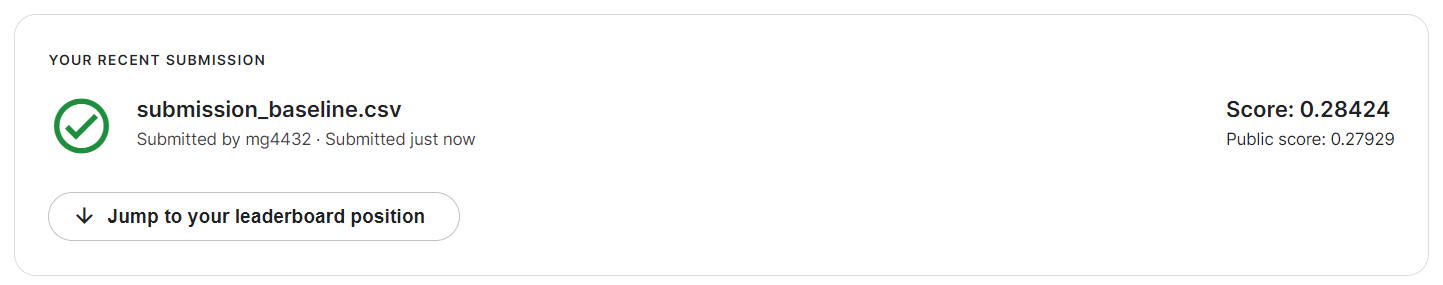

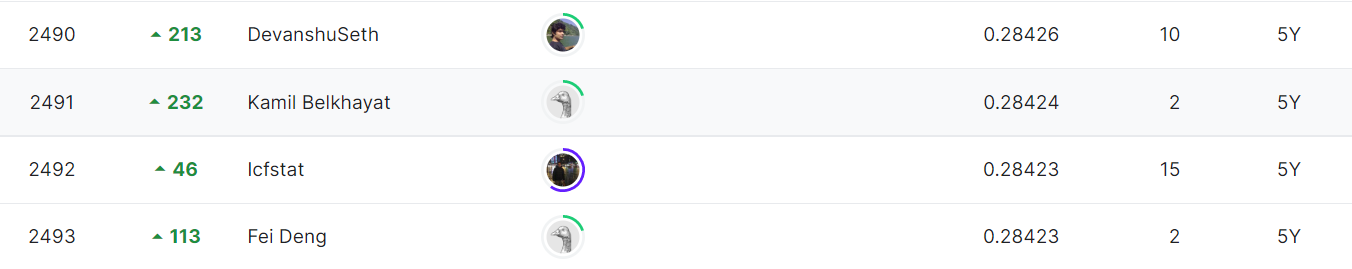